# Jupyter notebook
## Data cleaning and transformation
The dataset is compromised because of communications problems with the telematics system, resulting in rentals having to be cancelled either immediately or within an hour. Eliminating rentals with rental durations of less than an hour takes care of mopeds that did not start or had some other kind of issue which meant that a swap was required. While it would have been preferable to remove these data points statistically, the IQR method cut out a lot of valid rentals. A histogram of rental duration shows that there are outliers of long duration that can be removed statistically.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
elmovo_loc = os.path.join(os.getcwd(), 'Elmovo_rentals_12-1-2020.csv')
elmovo = pd.read_csv(elmovo_loc)

#Check for duplicates and null values

print(elmovo.duplicated().value_counts())
print(elmovo.isnull().sum())
print(elmovo.info())

False    4631
dtype: int64
id                                0
state                             0
start_kilometers                  0
start_position                    0
start_time                        0
start_address                     4
end_kilometers                    0
end_position                      0
end_time                          0
end_address                       1
price_for_driving_gross           0
price_for_driving_net             0
price_for_parking_gross           0
price_for_parking_net             0
price_for_reservation_gross       0
price_for_reservation_net         0
rebate_gross                      0
rebate_net                        0
time_driving                      0
time_parking                      0
time_reservation                  0
branch_id                         0
end_branch_id                     0
guser_id                          0
vehicle_id                        0
invoice_id                     3351
rating                         4018
r

There are no duplicates. None of the null values are in columns that will be analysed, so they can be ignored.

In [3]:
elmovo['rental_duration'] = elmovo['time_driving']/3600 + elmovo['time_parking']/3600


count    4631.000000
mean        4.291900
std         2.989462
min         0.000000
25%         2.876528
50%         4.601389
75%         5.632917
max        83.497500
Name: rental_duration, dtype: float64


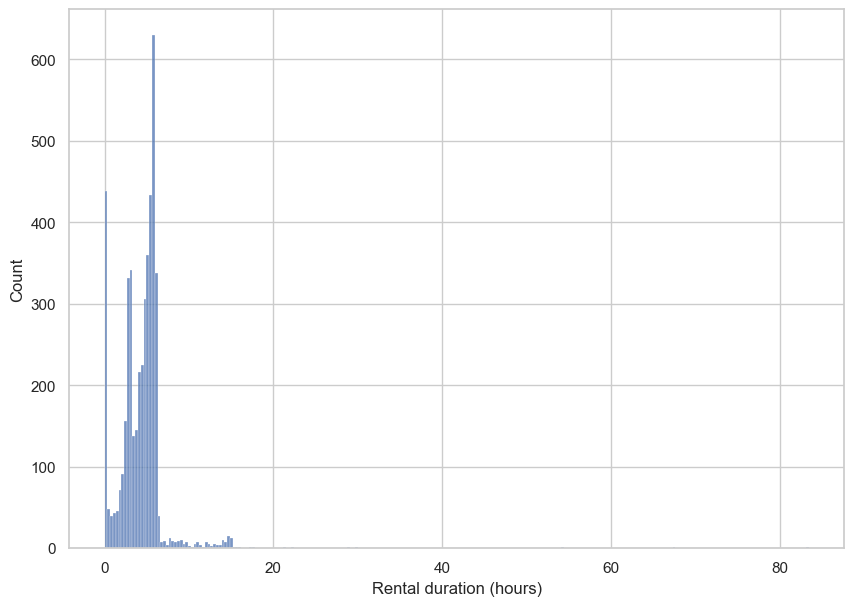

In [4]:
sns.set_theme(rc={"figure.figsize":(10, 7)})
sns.set_style('whitegrid')
sns.histplot(elmovo['rental_duration'])
plt.xlabel('Rental duration (hours)')
print(elmovo['rental_duration'].describe())

Outliers of long duration are mostly due to riders forgetting to end their rental sessions. The large number of outliers of extremely short duration are due to technical problems and errors by riders when making bookings. Any rental of under one hour does not reflect the performance of the mopeds and can be ignored. Trying to remove these rentals statistically using the IQR removes almost all 3-hour rental data.

count    3997.000000
mean        4.528030
std         1.440145
min         1.040556
25%         3.181389
50%         4.844444
75%         5.661944
max        10.325556
Name: rental_duration, dtype: float64


<AxesSubplot: xlabel='rental_duration', ylabel='Count'>

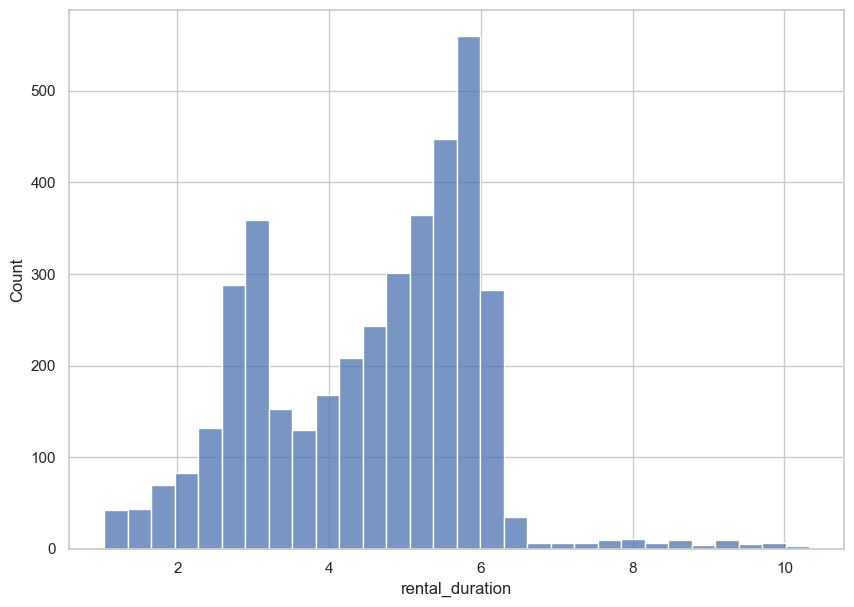

In [5]:
Q1 = elmovo['rental_duration'].quantile(.25)
Q3 = elmovo['rental_duration'].quantile(.75)
IQR = Q3 - Q1
filtered_elmovo = elmovo[(elmovo['rental_duration'] > 1) & (elmovo['rental_duration'] < (Q3 + 1.75 * IQR))].copy()
print(filtered_elmovo['rental_duration'].describe())

sns.set_theme(rc={"figure.figsize":(10, 7)})
sns.set_style('whitegrid')
sns.histplot(filtered_elmovo['rental_duration'])

Two further adjustments are required. The first is to segment rentals into 3-hour and 6-hour sessions, which was not recorded in the data. Then limit the locations to those where rentals took place, as opposed to the service centre. The rentals are segmented into 3 and 6-hour using the gross price. The lowest cost of a 6-hour rental was £9

In [6]:
conditions = [
    (filtered_elmovo['price_for_driving_gross'] < 9),
    (filtered_elmovo['price_for_driving_gross'] >= 9)
]
values = ['3-hour', '6-hour']
filtered_elmovo['rental_type'] = np.select(conditions, values)

#We are interested in four 'branches' or rental locations
filtered_elmovo = filtered_elmovo[filtered_elmovo.branch_id.isin([4, 6, 7, 8])]
print(filtered_elmovo['branch_id'].value_counts())

4    2319
7     875
6     544
8     257
Name: branch_id, dtype: int64


# Analysis
## Duration and distance of rentals by location

Text(0.5, 1.0, 'Fig 1. Duration of rentals by branch location')

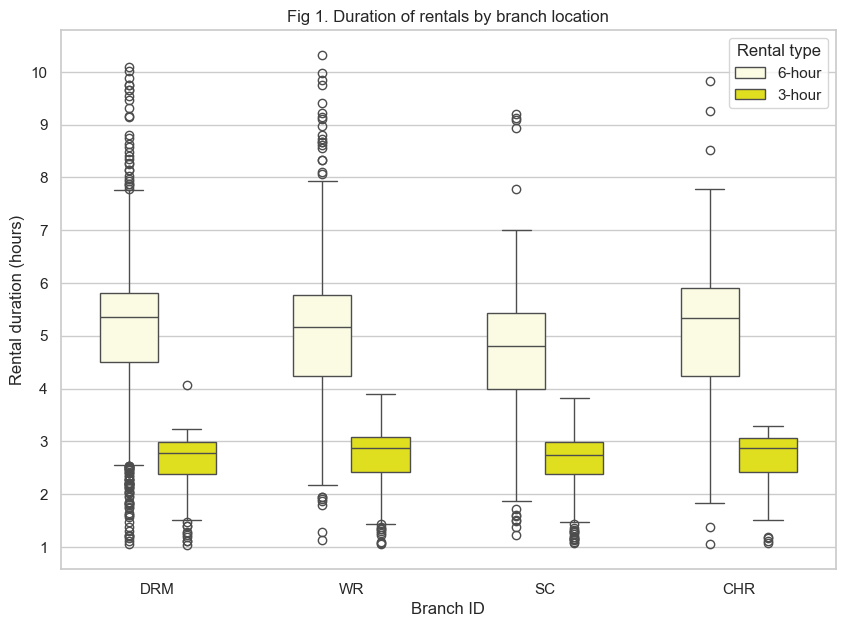

In [7]:


sns.set_theme(rc={"figure.figsize":(10, 7)})
sns.set_style('whitegrid')
rental_palette = {'6-hour': 'lightyellow', '3-hour': 'yellow'}
ax = sns.boxplot(data = filtered_elmovo, y='rental_duration', x='branch_id', palette=rental_palette, hue='rental_type', width=.6)
xticks = [0, 1 , 2, 3]
ax.set_xticks(xticks)
ax.set_xticklabels(['DRM', 'WR', 'SC', 'CHR'])
ax.set(xlabel='Branch ID', ylabel='Rental duration (hours)')
plt.yticks(range(int(min(filtered_elmovo['rental_duration'])), int(max(filtered_elmovo['rental_duration']))+1))
plt.legend(loc='upper right', title='Rental type')
plt.title('Fig 1. Duration of rentals by branch location')


A further adjustment is required before plotting distance data as fixing the communication issue meant that we lost odometer readings from the mopeds, so there are rentals where the start and end kilometers don't change and produce a calculated 'rental_distance' of zero. These data are removed at this point as the duration information is all valid and so should be included in the above plot. There is only one 'rental_distance' at CHR, so this will be removed.

Text(0.5, 0, 'Rental distance (miles)')

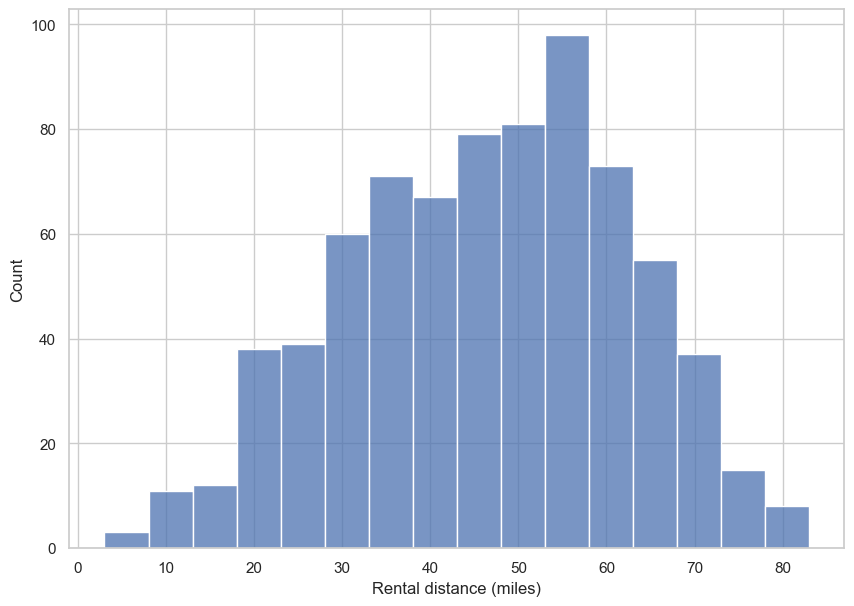

In [8]:

filtered_elmovo['rental_distance'] = filtered_elmovo['end_kilometers'] - filtered_elmovo['start_kilometers']
distance_filtered_elmovo = filtered_elmovo[(filtered_elmovo['rental_distance'] !=0) & (filtered_elmovo['branch_id'] !=8)]

sns.set_theme(rc={"figure.figsize":(10, 7)})
sns.set_style('whitegrid')
sns.histplot(distance_filtered_elmovo['rental_distance'])
plt.xlabel('Rental distance (miles)')
# print(distance_filtered_elmovo['rental_distance'].describe())

Text(0.5, 1.0, 'Fig 2. Distance of rentals by branch location')

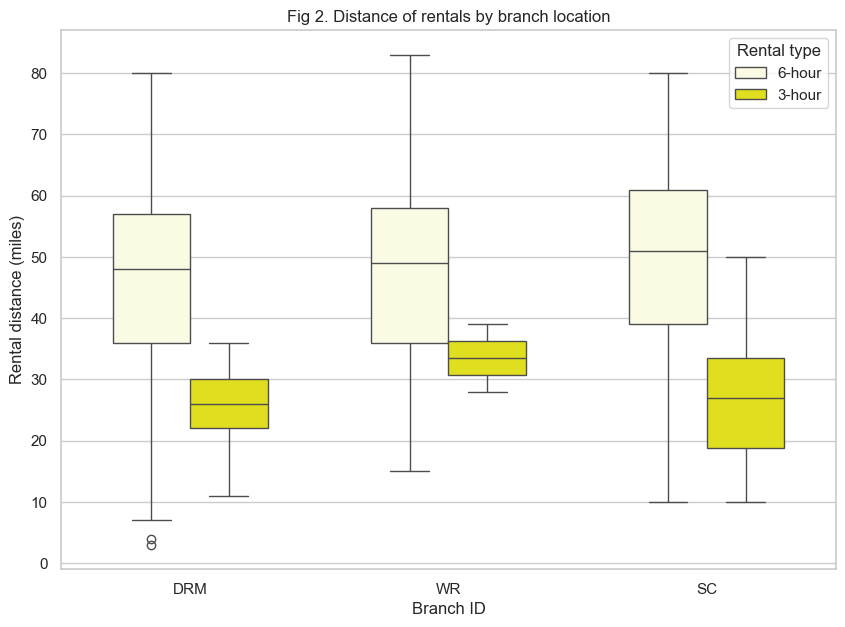

In [9]:
sns.set_theme(rc={"figure.figsize":(10, 7)})
sns.set_style('whitegrid')
ax = sns.boxplot(data = distance_filtered_elmovo, y='rental_distance', x='branch_id', palette=rental_palette, hue='rental_type', width=.6)
xticks = [0, 1 , 2]
ax.set_xticks(xticks)
ax.set_xticklabels(['DRM', 'WR', 'SC'])
ax.set(xlabel='Branch ID', ylabel='Rental distance (miles)')
plt.legend(loc='upper right', title='Rental type')
plt.title('Fig 2. Distance of rentals by branch location')

The next analysis is of rental start times, first by a violinplot normalised by area. This has to be considered in combination with a barplot of the average number of 3-hour and 6-hour rentals per day.

Text(0.5, 1.0, 'Fig 3a. Hour of rental start time by day')

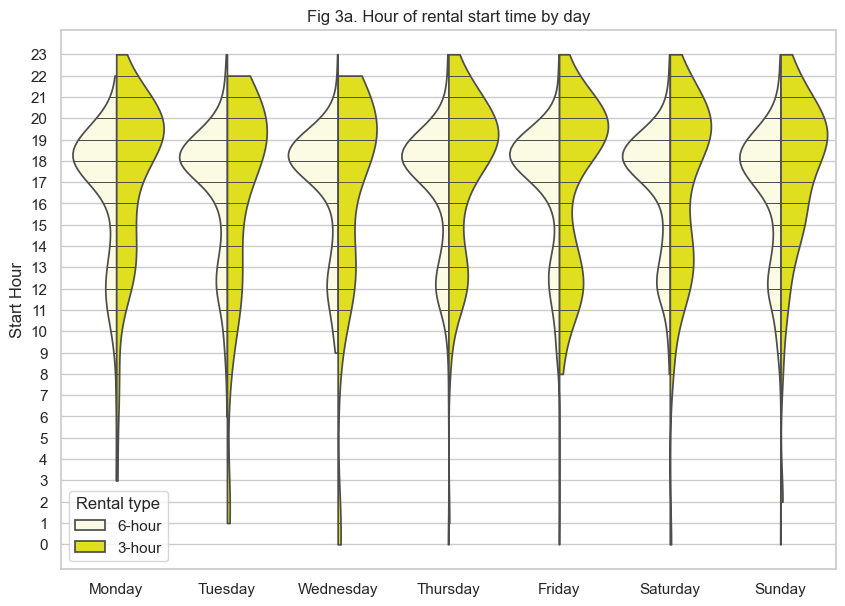

In [10]:

#We need to convert the start time to a datetime object
filtered_elmovo['start_time'] = pd.to_datetime(filtered_elmovo['start_time'], format='%Y-%m-%d %H:%M:%S')
filtered_elmovo['start_day'] = filtered_elmovo['start_time'].dt.day_name()
filtered_elmovo['start_hour'] = filtered_elmovo['start_time'].dt.hour
#print(filtered_elmovo.start_hour.describe())


sns.set_theme(rc={"figure.figsize":(10, 7)})
sns.set_style('whitegrid')
sns.violinplot(data=filtered_elmovo, x='start_day', y='start_hour', cut=0, hue='rental_type', palette=rental_palette, density_norm='area', inner='stick', width= 0.9, split=True, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.yticks(range(int(min(filtered_elmovo['start_hour'])), int(max(filtered_elmovo['start_hour']))+1))
plt.xlabel(None) 
plt.ylabel('Start Hour')
plt.legend(loc='lower left', title='Rental type')
plt.title('Fig 3a. Hour of rental start time by day')

Text(0.5, 1.0, 'Fig 3b. Hour of rental start time (Average per Day)')

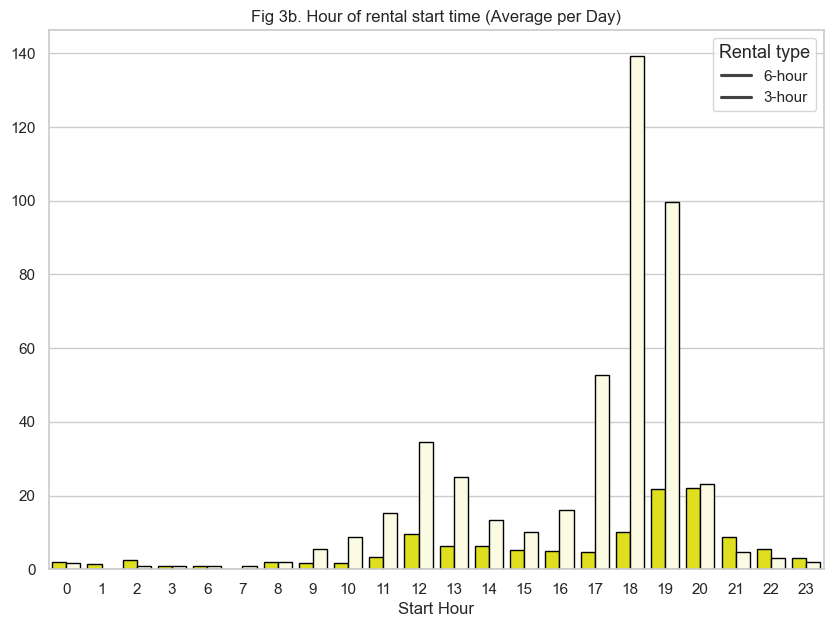

In [11]:
# Group by start_day, start_hour, and rental_type and calculate the average count
average_count_per_day = filtered_elmovo.groupby(['start_day', 'start_hour', 'rental_type']).size().groupby(['start_hour', 'rental_type']).mean().reset_index(name='average_count')
sns.set_theme(rc={"figure.figsize":(10, 7)})
sns.set_style('whitegrid')
sns.barplot(data=average_count_per_day, x='start_hour', y='average_count', hue='rental_type', palette=rental_palette, edgecolor='black')
plt.xlabel('Start Hour')
plt.ylabel(None)
plt.legend(title='Rental type', title_fontsize='13', labels=['6-hour', '3-hour'])


plt.title('Fig 3b. Hour of rental start time (Average per Day)')
